In [1]:
import sys
sys.path.insert(1, '/Users/mac/Desktop/PycharmProjects/TAADL/src')
sys.path.insert(2, '/Users/mac/Desktop/PycharmProjects/TAADL/models')

In [2]:
import logging
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

from config import DATA_PATH
from network import GPCopulaNet
from loader import EvalDataset
from torch.utils.data import DataLoader
from utils import train_test_split, transform, inv_transform_3D, plot_prediction

# Data Preprocessing

In [22]:
# load and preprocess the data
feature = pd.read_csv(DATA_PATH+'log_return.csv', index_col='Date')
df_tr, df_te = train_test_split(feature)
_, cdf_tr = transform(torch.Tensor(df_tr.values))

# load data
dataset = EvalDataset(feature)
loader  = DataLoader(dataset, batch_size=1)

In [5]:
# call trained model by loading state dict
net = GPCopulaNet(input_dim=1, hidden_dim=15, embed_dim=6, num_layers=2,
                    num_assets=7, seq_length=24, pred_length=4, batch_size=1, rank_size=2)
net.init_weight()
parameters = torch.load('/Users/mac/Desktop/PycharmProjects/TAADL/models/GPCopulaNet_mean.pt')
net.load_state_dict(parameters['net_params'])

<All keys matched successfully>

In [17]:
def assess_prediction(
        model:nn.Module,
        dataset:torch.utils.data.Dataset, 
        cdf:dict,
        num_samples:int
    ) -> torch.Tensor:
    
    logging.getLogger('GPCopula.Inference')

    model.eval()
    pred_mean, pred_uncertainty, truth, months = [], [], [], []
    loader = DataLoader(dataset, batch_size=1)

    print('Starting prediction tasks...')
    for test_batch, label, mth in tqdm(loader):
        test_batch = test_batch.squeeze(0)
        x_hat = model.predict(test_batch[-2:-1], num_samples, label.size(1))
        z_hat = inv_transform_3D(x_hat, cdf)
        z_mean, z_std = z_hat.mean(axis=0), z_hat.std(axis=0)
        
        # append data to the list respectively
        months.append(mth)
        pred_mean.append(z_mean)
        pred_uncertainty.append(z_std)
        truth.append(label.squeeze(0))

    print('Prediction finished. Starting loss calculation...')
    losses = torch.zeros((len(z_hat),1))
    loss_fn = nn.MSELoss()
    for t in tqdm(range(len(z_hat))):
        losses[t] = loss_fn(pred_mean[t], truth[t])
    
    print(f'Loss calculation done. Average MSE: {np.round(losses.mean().item(),4)} \n')
    # locate maximum loss and minimum loss
    max_idx, min_idx = torch.argmax(losses), torch.argmin(losses)
    
    print('Best Minimum Loss')
    print(f'Time: {months[min_idx.item()]}, Loss: {losses[min_idx.item()].item()}')
    plot_prediction(truth[min_idx.item()], pred_mean[min_idx.item()], pred_uncertainty[min_idx.item()], months[min_idx.item()][0], 'min')

    print('Best Maximum Loss')
    print(f'Time: {months[max_idx.item()]}, Loss: {losses[max_idx.item()].item()}')
    plot_prediction(truth[max_idx.item()], pred_mean[max_idx.item()], pred_uncertainty[max_idx.item()], months[max_idx.item()][0], 'max')

    print('Last Month')
    print(f'Time: {months[-1]}, Loss: {losses[-1].item()}')
    plot_prediction(truth[-1], pred_mean[-1], pred_uncertainty[-1], months[-1][0], 'latest')

Starting prediction tasks...


100%|██████████| 200/200 [00:21<00:00,  9.36it/s]


Prediction finished. Starting loss calculation...


100%|██████████| 10/10 [00:00<00:00, 15720.78it/s]


Loss calculation done. Average MSE: 0.0004 

Best Minimum Loss
Time: ('2005-07',), Loss: 0.00020377835240257316
Best Maximum Loss
Time: ('2006-01',), Loss: 0.000778706137093523
Last Month
Time: ('2022-02',), Loss: 0.0005248414057933193


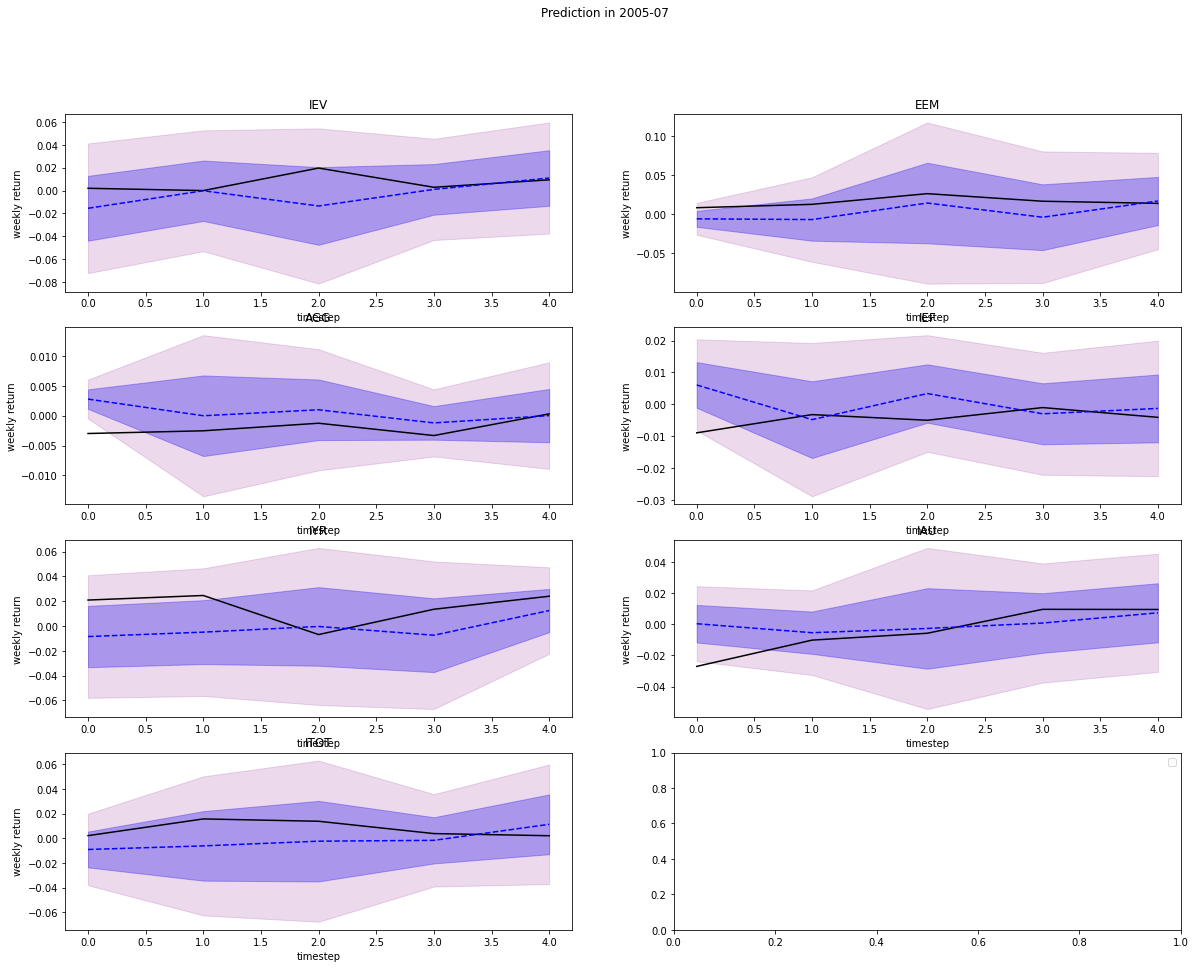

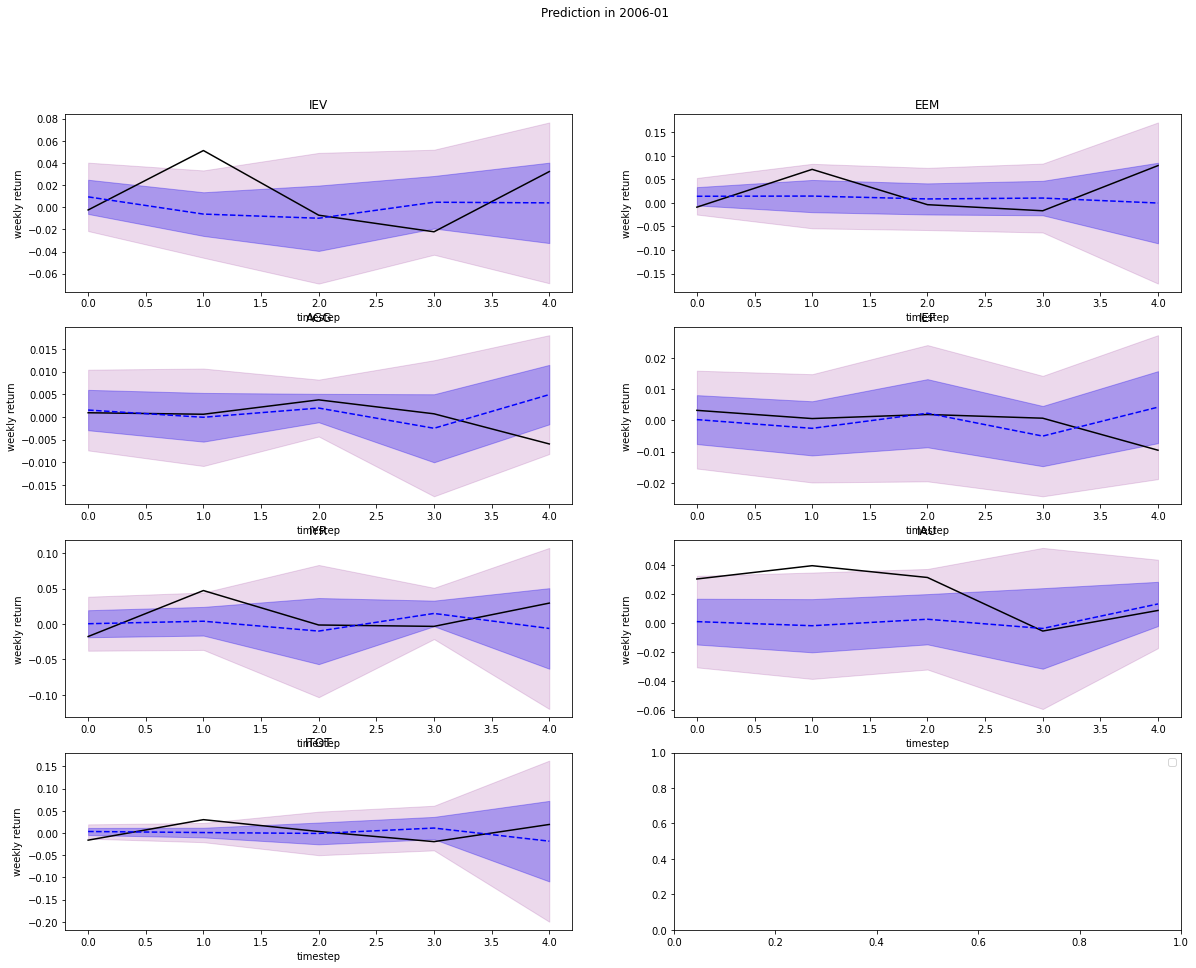

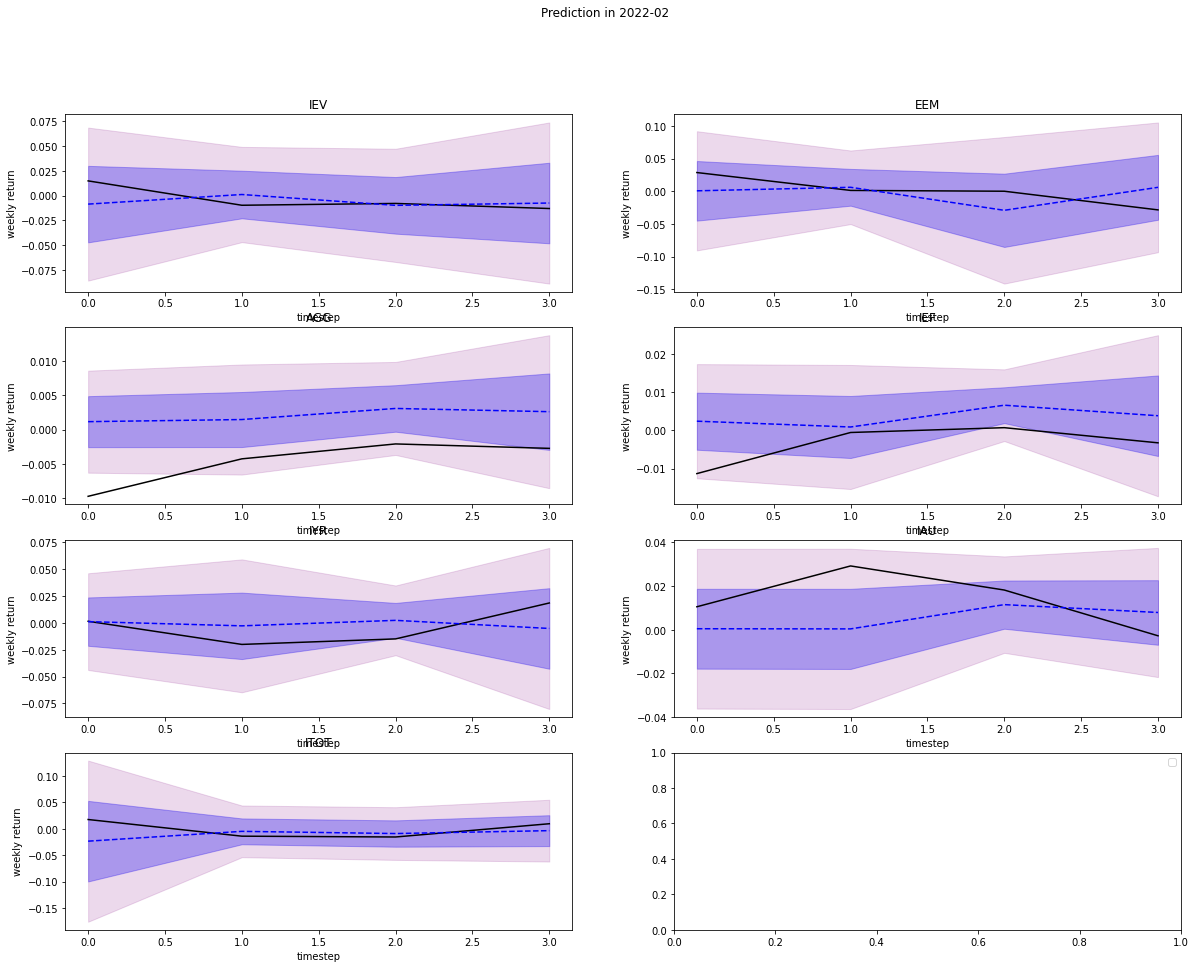

In [18]:
assess_prediction(net, dataset, cdf_tr, 10)